In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(f'Using {device} as device')

Using cuda as device


In [3]:
fact = pd.read_csv('train.csv')
fact = fact.drop(['Name', 'PassengerId'], axis = 1)
fact = fact.fillna(0)

unknown_data = pd.read_csv('test.csv')
unknown_data = unknown_data.drop(['Name', 'PassengerId'], axis = 1)
unknown_data = unknown_data.fillna(0)

unknown_data

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,34.5,0,0,330911,7.8292,0,Q
1,3,female,47.0,1,0,363272,7.0000,0,S
2,2,male,62.0,0,0,240276,9.6875,0,Q
3,3,male,27.0,0,0,315154,8.6625,0,S
4,3,female,22.0,1,1,3101298,12.2875,0,S
...,...,...,...,...,...,...,...,...,...
413,3,male,0.0,0,0,A.5. 3236,8.0500,0,S
414,1,female,39.0,0,0,PC 17758,108.9000,C105,C
415,3,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,0,S
416,3,male,0.0,0,0,359309,8.0500,0,S


In [4]:
fact_data = fact.drop('Survived', axis = 1)
fact_class = pd.get_dummies(fact['Survived'])

all_data = pd.concat([fact_data, unknown_data], axis = 0, ignore_index = True)
all_data = pd.get_dummies(all_data, columns = ['Sex', 'Embarked', 'Fare', 'Ticket', 'Cabin'])

all_data

,Pclass,Age,SibSp,Parch,Sex_female,Sex_male,Embarked_0,Embarked_C,Embarked_Q,Embarked_S,...,Cabin_F E57,Cabin_F E69,Cabin_F G63,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_T
0,3,22.0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,38.0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,26.0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,35.0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,3,35.0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0.0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1305,1,39.0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1306,3,38.5,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1307,3,0.0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


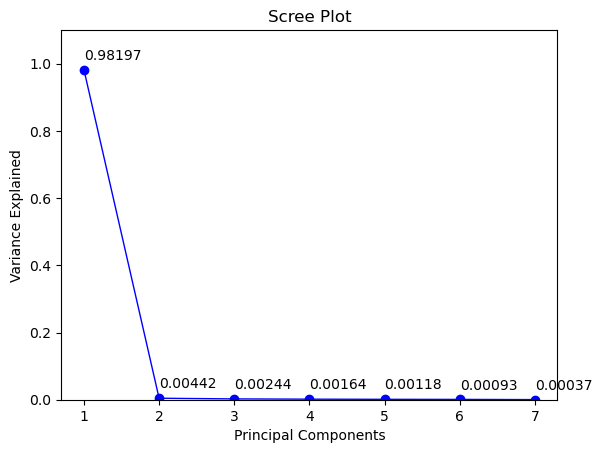

In [5]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

def pca_preprocessing(pc_number: int, fact_data, unknown_data):
    '''create and train pca model; transform train and test data'''
    pca_model = PCA(n_components = pc_number, random_state = 0)
    pca_model.fit(fact_data)
    pca_scree_plot(pca_model)
    return pca_model.transform(fact_data), pca_model.transform(unknown_data)

def pca_scree_plot(pca_model):
    '''plot variance for each principle component of given pca model'''
    pc_values = np.arange(pca_model.n_components_) + 1
    plt.plot(pc_values, pca_model.explained_variance_ratio_, 'o-', linewidth=1, color='blue')
    plt.title('Scree Plot')
    plt.xlabel('Principal Components')
    plt.ylabel('Variance Explained')
    plt.xlim(pc_values[0] - 0.3, pc_values[-1] + 0.3)
    plt.ylim(0, 1.1)
    plt.xticks(pc_values)

    for i,j in zip(pc_values, pca_model.explained_variance_ratio_):
        plt.annotate(str(round(j, 5)), xy = (i,j), xytext = (i, j + 0.03))

fact_data, unknown_data = pca_preprocessing(7, all_data.iloc[:891], all_data.iloc[891:])

In [6]:
class LinNet(nn.Module):
    def __init__(self, input_layers, hidden_layers, output_layers):
        super(LinNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_layers, hidden_layers),
            nn.BatchNorm1d(hidden_layers, 1),
            nn.LeakyReLU(negative_slope = 0.01),

            nn.Linear(hidden_layers, output_layers),
        )
    def forward(self, x):
        return self.layers(x)

In [7]:
from torch.utils.data import DataLoader
from IPython import display
from sklearn.model_selection import train_test_split

def train_test_losses(train_losses: list, test_losses: list):
    '''Displays model losses on test and train datasets'''

    plt.plot(train_losses, label='Train Loss', color = 'blue')
    plt.plot(test_losses, label='Test Loss', color = 'orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Test Loss')
    plt.legend()

    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.close()

def datasets_to_loaders(data, classes, batch_size: int):
    '''pair class label and data to create dataloader (shuffle = False)'''
    array = []
    tensor_data = torch.tensor(data, dtype = float)
    tensor_classes = torch.tensor(classes, dtype = float)

    for i in range(len(data)):
        array.append([tensor_data[i], tensor_classes[i]])

    loader = DataLoader(array, batch_size = batch_size, shuffle = False)
    return loader

def create_data_loaders(fact_data, fact_classes, train_size: float, batch_size: int):
    '''Split data and classes into train/test (train_size = train_dataset_size/full_dataset_size)
    datasets and create DataLoaders (shuffle = False)'''
    train_data, test_data, train_class, test_class = train_test_split(np.array(fact_data), np.array(fact_classes),
                                                                      train_size = train_size)

    train_loader = datasets_to_loaders(train_data, train_class, batch_size)
    test_loader = datasets_to_loaders(test_data, test_class, batch_size)
    return train_loader, test_loader

def LinNet_classification (model, test_loader):
    '''Returns predicted and true classes (0 or 1) for test dataset'''
    pred_val = []
    true_val = []

    for _, (data, classes) in enumerate(test_loader):
        data = data.to(device)
        outputs = model(data.float()).detach().cpu().numpy()
        classes = classes.detach().cpu().numpy()

        for k in range(np.shape(outputs)[0]):
            pred_val.append(np.argmax(outputs[k, :]))
            true_val.append(np.argmax(classes[k, :]))
    return pred_val, true_val

def model_metrics(model, test_loader):
    '''Metrics for trained model 
    (f1_score, balanced_accuracy_score, ConfusionMatrixDisplay), 
    returns nothing'''
    from sklearn.metrics import f1_score, balanced_accuracy_score, ConfusionMatrixDisplay

    pred_val, true_val = LinNet_classification(model, test_loader)

    print(f'F1 score = {f1_score(true_val, pred_val, average = "micro")}')
    print(f'Balanced accuracy score = {balanced_accuracy_score(true_val, pred_val)}')
    display = ConfusionMatrixDisplay.from_predictions(true_val, pred_val)

In [8]:
train_loader, test_loader = create_data_loaders(fact_data, fact_class, 0.9, 101)

In [9]:
def train_loop(model, train_loader, optimizer, criterion):
    train_loss = 0
    for _, (data, classes) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        outputs = model(data.float())
        loss = criterion(outputs, classes.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss

def test_loop(model, test_loader, criterion):
    test_loss = 0
    for _, (data, classes) in enumerate(test_loader):
        data = data.to(device)
        outputs = model(data.float())
        loss = criterion(outputs, classes.to(device))
        test_loss += loss.item()
    return test_loss

def train_LinNet(model, train_loader, test_loader, num_epochs: int, lr: int):
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()

    test_losses = []
    train_losses = []

    for _ in range(num_epochs):
        model.train()
        train_loss = train_loop(model, train_loader, optimizer, criterion)
        
        avg_train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        
        with torch.no_grad():
            model.eval()
            test_loss = test_loop(model, test_loader, criterion)
        
        avg_test_loss = test_loss / len(test_loader.dataset)
        test_losses.append(avg_test_loss)
        
        train_test_losses(train_losses = train_losses, test_losses = test_losses)

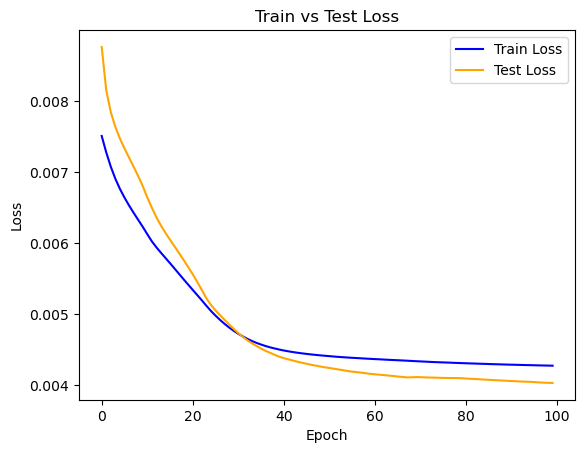

In [15]:
model = LinNet(7, 12, 2).to(device)
train_LinNet(model, train_loader, test_loader, num_epochs = 100, lr = 0.001)

F1 score = 0.8222222222222222
Balanced accuracy score = 0.7993697478991597


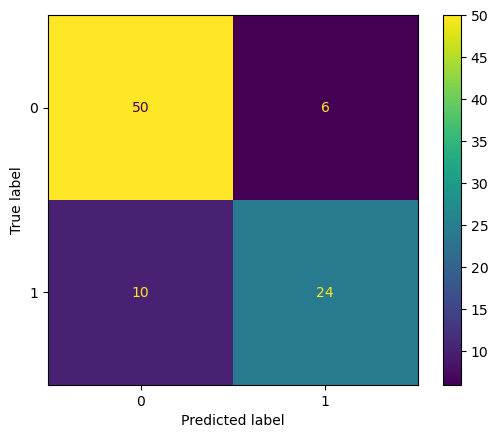

In [16]:
model_metrics(model, test_loader)

In [12]:
def LinNet_prediction(model, eval_loader):
    '''return classes (0 or 1), predicted for unknown data'''
    pred_val =[]
    for _, data in enumerate(eval_loader):
        data = data.to(device)
        outputs = model(data.float()).detach().cpu().numpy()
        for k in range(np.shape(outputs)[0]):
            pred_val.append(np.argmax(outputs[k, :]))
    return pred_val

eval_loader  = DataLoader(torch.tensor(unknown_data), batch_size = 50, shuffle=False)
pred = LinNet_prediction(model, eval_loader)
pred = pd.DataFrame(pred, columns =['Survived'])
id = pd.DataFrame(range(892, 1310), columns =['PassengerId'])
answer = pd.concat([id, pred], axis = 1)
print(answer)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


In [14]:
#answer.to_csv('predictions_3.csv', index = False)